Welcome to the Binary Classification with a Bank Churn Dataset notebook! In 'Binary Classification with a Bank Churn' project, we will explore a dataset that details various aspects contributing to customer churn prediction. Our objective is to predict whether a customer will choose to leave or stay.

The dataset includes diverse features such as customerID, Surname, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, and more, encompassing both numerical and categorical variables. Upon analysis, we have identified certain numerical features that, despite their numeric format, need to be treated as categorical. Additionally, through a deeper understanding of the features, We have introduced new features to not only enhance prediction accuracy but also minimize prediction errors, ultimately contributing to the creation of a robust model

The core structure of the project involves a combination of pipelines, encompassing data preprocessing and engineered features. These components will merge into an ensemble learning approach, utilizing both LGBM and XGBoost. Subsequently, a weighted voting classifier will amalgamate these models to make the final prediction on whether a customer will exit or remain.

# Import + Load Data

In [1]:
# Data Manipulation and Analysis
import numpy as np 
import pandas as pd 

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection
from sklearn.feature_selection import mutual_info_classif

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessors
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder

# Model Building
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

# Cross validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.model_selection import train_test_split

# Statistical Analysis
from scipy.stats import chi2_contingency

# Metrices
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

# Hyperparameter Tuning
import optuna

# Warnings
import warnings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


### <b>Remove User Warning</b>

In [3]:
#warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore")

In [4]:
# Reading the training data from the CSV file into the 'bankChunk_train' DataFrame
bankChunk_train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")

# Reading the test data from the CSV file into the 'bankChunk_test' DataFrame
bankChunk_test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

# Data Cleaning 

In [5]:
df_bankChunk_train = bankChunk_train.copy()
df_bankChunk_test = bankChunk_test.copy()

### <b>Drop Irrelevant Columns</b>

In [6]:
# Drop 'id' and 'CustomerId' from both training and testing dataset
df_bankChunk_train.drop(['id', 'CustomerId'], axis=1, inplace=True)
df_bankChunk_test.drop(['id', 'CustomerId'], axis=1, inplace=True)

# Basic EDA

In [7]:
# Training dataset and Testing dataset dimensions
print("Training Dataset :",df_bankChunk_train.shape)
print("Testing Dataset :", df_bankChunk_test.shape)

Training Dataset : (165034, 12)
Testing Dataset : (110023, 11)


In [8]:
df_bankChunk_train.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [9]:
# information about the training dataset
df_bankChunk_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Surname          165034 non-null  object 
 1   CreditScore      165034 non-null  int64  
 2   Geography        165034 non-null  object 
 3   Gender           165034 non-null  object 
 4   Age              165034 non-null  float64
 5   Tenure           165034 non-null  int64  
 6   Balance          165034 non-null  float64
 7   NumOfProducts    165034 non-null  int64  
 8   HasCrCard        165034 non-null  float64
 9   IsActiveMember   165034 non-null  float64
 10  EstimatedSalary  165034 non-null  float64
 11  Exited           165034 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 15.1+ MB


In [10]:
total_count = len(df_bankChunk_train)
total_count

165034

### <b>Percentage of Exited</b>

<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>⚠️ Imbalanced Dataset: </b> Based on the calculated percentages, it is evident that this dataset is highly imbalanced. Models may pay more attention to customers who exist rather than those who leave. Therefore, we need to implement strategies to handle the imbalance in the dataset.
</div>


In [11]:
# calculating the percentage of customers that exist and leave in the training dataset
print("Customer Exists :", (df_bankChunk_train['Exited'].value_counts()[0] / total_count) * 100, "%")
print("Customer Leaves :", (df_bankChunk_train['Exited'].value_counts()[1] / total_count) * 100, "%")

Customer Exists : 78.84011779390914 %
Customer Leaves : 21.159882206090867 %


### <b>Null values</b>

In [12]:
print("Misssing values in tranning dataset :", df_bankChunk_train.isna().sum().sum())
print("Misssing values in testing dataset :", df_bankChunk_test.isna().sum().sum())

Misssing values in tranning dataset : 0
Misssing values in testing dataset : 0


### <b>Summary Statistics</b>

In [13]:
def summary_style(df, caption=""):
    return df.style.background_gradient(cmap="cividis").set_caption(caption).set_table_styles([{
        'selector' : 'caption',
        'props' : [
            ('font-size', '23px'),
            ('font-family', 'cursive'),
            ('color', '#14213d'),
            ('font-weight', 'bold'),
            ('font-weight', 'bold'),
            ('text-align', 'left'),
            ('padding', '10px')
        ]
    }])

In [14]:
display(summary_style(df_bankChunk_train.describe(), "Summary Statistics"))
display(summary_style(df_bankChunk_train.nunique().to_frame().rename({0 : 'Unique Value Count'}, axis=1).transpose(), "Training Dataset Unique Value Counts"))
display(summary_style(df_bankChunk_test.nunique().to_frame().rename({0 : 'Unique Value Count'}, axis=1).transpose(), "Testing Dataset Unique Value Counts"))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Unique Value Count,2797,457,3,2,71,11,30075,4,2,2,55298,2


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Unique Value Count,2708,454,3,2,74,11,22513,4,2,2,41670


### <b>Sample Data</b>

In [15]:
df_bankChunk_train.sample(10)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
64796,Nnachetam,558,France,Female,51.0,1,0.00,1,1.0,0.0,162033.09,1
98094,Tien,651,France,Female,41.0,4,0.00,2,0.0,0.0,100722.72,0
130414,Chijindum,629,France,Male,34.0,2,0.00,2,0.0,0.0,12096.17,0
76196,P'eng,613,France,Female,27.0,0,0.00,2,1.0,0.0,90177.15,0
39852,Onyemauchechukwu,597,France,Female,34.0,5,0.00,2,0.0,1.0,74854.97,0
69897,Pugh,521,France,Female,34.0,8,0.00,2,1.0,0.0,139024.31,0
83761,Bage,648,Spain,Male,30.0,2,0.00,2,1.0,1.0,140746.28,0
422,Tsao,625,France,Female,55.0,1,0.00,2,1.0,1.0,125762.99,0
37760,Obidimkpa,589,France,Male,29.0,3,0.00,2,1.0,1.0,173432.83,0
54064,T'ang,586,Spain,Male,34.0,8,142310.52,1,1.0,1.0,138527.24,0


In [16]:
numerical_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary' ]
numerical_features

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b>  As discussed earlier, despite some features being in integer or float format, we have categorized them as categorical. This decision was made because, in the context of this dataset, classifying these features as categorical is expected to enhance the overall model performance.

In [17]:
categorical_features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember' ]
categorical_features

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

### <b>Feature Distribution</b>

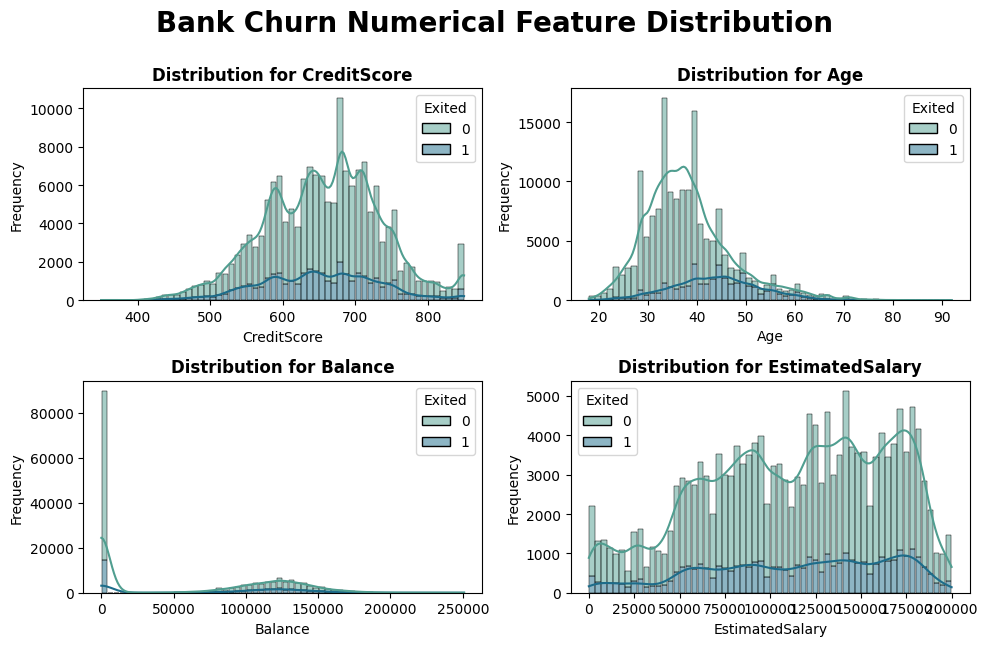

In [18]:
figure, axs = plt.subplots(2, 2, figsize=(10,6))

for col, ax in zip(numerical_features, axs.ravel()):
    sns.histplot(data=df_bankChunk_train, x=col, hue="Exited", palette="crest", multiple="stack", kde =True, bins=60, shrink=0.9,ax=ax)
    ax.set_title(f'Distribution for {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
     
plt.tight_layout()
plt.suptitle("Bank Churn Numerical Feature Distribution", y=1.07, fontsize=20, fontweight='bold')
plt.show()

In [19]:
# Creating a DataFrame 'Leaved' containing records of customers who have exited (Exited == 1)
Leaved = df_bankChunk_train[df_bankChunk_train['Exited'] == 1]

# Creating a DataFrame 'Exists' containing records of customers who have not exited (Exited == 0)
Exists = df_bankChunk_train[df_bankChunk_train['Exited'] == 0]

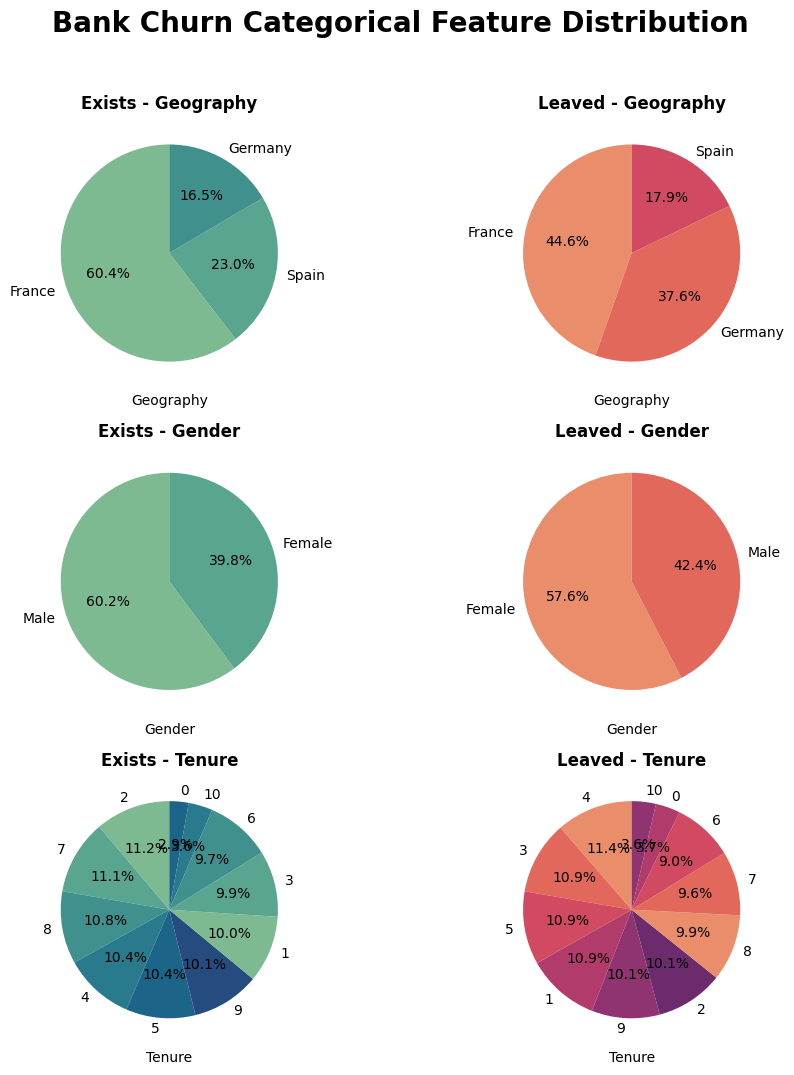

In [20]:
# Create subplots for visualizing categorical feature distributions
figure, axs = plt.subplots(3, 2, figsize=(10,10))

# Iterate through categorical features
for col, (ax1, ax2) in zip(categorical_features, axs):
    # Plot pie chart for 'Exists' customers
    counts_exists = Exists[col].value_counts()
    ax1.pie(counts_exists, labels=counts_exists.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("crest"))
    ax1.set_title(f'Exists - {col}', fontsize=12, fontweight='bold')
    ax1.set_xlabel(col, fontsize=10)
    
    # Plot pie chart for 'Leaved' customers
    counts_leaved = Leaved[col].value_counts()
    ax2.pie(counts_leaved, labels=counts_leaved.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("flare"))
    ax2.set_title(f'Leaved - {col}', fontsize=12, fontweight='bold')
    ax2.set_xlabel(col, fontsize=10)

# Adjust layout and display the plots
plt.tight_layout()
plt.suptitle("Bank Churn Categorical Feature Distribution", y=1.07, fontsize=20, fontweight='bold')
plt.show()


<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note:</b> Based on the categorical feature distributions, the 'Geography' and 'Gender' features contain valuable information about the customer status.
</div>

### <b>Correlation Analysis</b>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Correation Heatmap:</b> The correlation heatmap is a valuable tool for gaining insights into your dataset, helping you identify relationships between variables, and potentially informing feature selection or further analysis.
    <ul>
        <li>A values close to 1 indicates a strong positive linear correlation, meaning that as one variable increases, the other also increases linearly.</li>
        <li>A values close -1 indicates a perfect negative correlation, meaning that as one variable increases, the other decreases linearly.</li>
        <li>A value of 0 indicates no linear correlation between the variables.</li>
    </ul>
</div>

In [21]:
numerical_features_corr = df_bankChunk_train.select_dtypes(include=['int64', 'float64']).columns
numerical_features_corr

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Text(0.5, 1.07, 'Correlation Analysis')

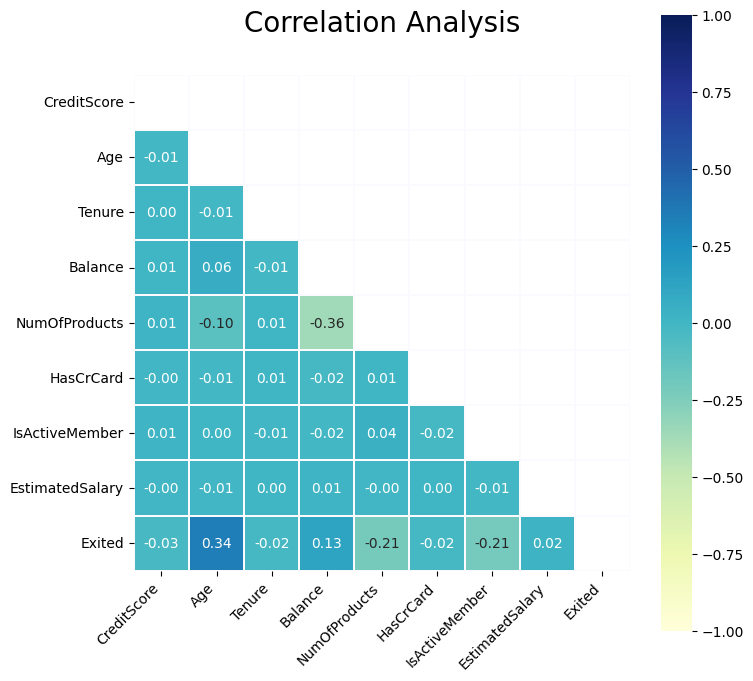

In [22]:
corr_matrix = df_bankChunk_train[numerical_features_corr].corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', 
            linewidth=0.1, vmax=1.0, vmin=-1.0, linecolor="#fafaff", fmt='.2f', square=True, mask=mask)

plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Correlation Analysis", y=1.07, fontsize=20)

### <b>Chi-Squared Test</b>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Chi-Squared Test:</b> The chi-squared test is a statistical hypothesis test used to determine if there is a significant association between two categorical variables. It is often used to assess whether there is a relationship between a categorical independent variables and the categorical dependent variable. The test is based on the differences between the expected and observed frequencies in a contingency table.
    <ul>
        <li><code>Null Hypothesis (H0)</code>: There is no significant association between the two categorical variables; they are independent.</li>
        <li><code>Alternative Hypothesis (H1)</code>: There is a significant association between the two categorical variables; they are dependent.</li>
        <li><code>crosstab</code>: Construct a contingency table that summarizes the observed counts of the data and Calculate the expected frequencies for each cell in the contingency table under the assumption that the variables are independent</li>
        <li><code>chi-squared</code>: Calculate the difference between the observed and expected frequencies.</li>
        <li><code>p-value</code>: Calculate the p-value associated with the test statistic. The p-value represents the probability of observing a test statistic
        <br><br>
        <li>Compare the p-value to a predetermined significance level (e.g., 0.05). If the p-value is less than the significance level, reject the null hypothesis that means there is significant association between the two categorical variables. If there is no significant association between the two categorical variables null hypothesis is accepted. So based on this we can exclude the features that have values <b>higher than the predetermined significance level.</b></li>
</div>

In [23]:
value_counts = df_bankChunk_train.nunique()
categorical_values = value_counts[(value_counts > 1) & (value_counts < 20)].index.tolist()
categorical_features_chi = list(set(categorical_values) - set(['Exited']))

In [24]:
threshold = 0.05

print(f'\033[34m{"Columns":<26} | {f"Test score":<26} | Test result')
print("-" * 69)

for feature in categorical_features_chi:
    contingency_table = pd.crosstab(df_bankChunk_train['Exited'], df_bankChunk_train[feature])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    if p < threshold:
        print(f"\033[36m{feature:<28}{p:<28}Passed")
    else:
        print(f"\033[31m{feature:<28}{p:<28}Failed")        

Columns                    | Test score                 | Test result
---------------------------------------------------------------------
HasCrCard                   2.522692566848213e-19       Passed
IsActiveMember              0.0                         Passed
NumOfProducts               0.0                         Passed
Tenure                      3.028684145775075e-51       Passed
Gender                      0.0                         Passed
Geography                   0.0                         Passed


# Feature Engineering

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note:</b> Creating a custom transformer can be easily integrated into scikit-learn pipelines. This makes it convenient to organize and execute a sequence of data processing steps in a systematic way. Additionally, the logic for transforming the columns is encapsulated within the custom transformer. This promotes cleaner and more modular code by keeping the transformation logic in one place, making it easier to understand and maintain.
</div>


### <b>Age Binning</b>

In [25]:
# Define a custom transformer and inherit BaseEstimator and TransformerMixin
class AgeBinning(BaseEstimator, TransformerMixin):
    
    # Constructor method to initialize the transformer with the number of bins
    def __init__(self, n_bins):
        self.n_bins = n_bins
        
    # Fit method - in this case, no actual fitting is done, so it just returns self
    def fit(self, X, y=None):
        return self
    
    # Transform method - performs the actual transformation on the input data
    def transform(self, X, y=None):
        # Use pandas qcut function to perform quantile-based binning on the 'Age' column
        transformed = pd.qcut(X['Age'], self.n_bins, labels=False)

        # Handle missing values by replacing them with 0
        transformed[transformed.isna()] = 0
        
        # Create a new pandas Series with the transformed values, and assign a name to it
        transformed_series = pd.Series(transformed,
                                       name='AgeBinning',
                                       index=X.index)
        
        # Create a copy of the input DataFrame to avoid modifying the original data
        X_copy = X.copy()
        
        # Concatenate the new Series with the original DataFrame
        return pd.concat([X_copy, transformed_series], axis=1)
    
# Leverage the fit_transform method provided by TransformerMixin    
AgeBinning(5).fit_transform(df_bankChunk_train)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeBinning
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,3
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,1
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0


### <b>CreaditScore Binning</b>

In [26]:
class CreaditBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['CreditScore'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed,
                                       name='CreaditBinning',
                                       index=X.index)
        
        X_copy = X.copy()
        
        return pd.concat([X_copy, transformed_series], axis=1)
    
CreaditBinning(10).fit_transform(df_bankChunk_train)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreaditBinning
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,5
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,3
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,5
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,5
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,9
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,1
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0


### <b>EstimatedSalary Binning</b>

referenced from: https://www.kaggle.com/code/yorkyong/churn-prediction-ensemble-w-cb-xgb-lgbm#3.-Feature-Engineering

In [27]:
class EstimatedSalary(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['EstimatedSalary'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed,
                                       name='EstimatedSalarybinning',
                                       index=X.index)
        
        X_copy = X.copy()
        
        return pd.concat([X_copy, transformed_series], axis=1)
    
EstimatedSalary(10).fit_transform(df_bankChunk_train)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,EstimatedSalarybinning
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,9
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,9
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,3
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,5
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,5
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,5
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2


### <b>BalanceSalaryRatio</b>

In [28]:
class BalanceSalaryRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        # The purpose of adding 1 to the numerator (in this case, X_copy['Balance']) is to avoid division by zero
        X_copy['BalanceSalaryRatio'] = (X_copy['Balance'] + 1) / X_copy['EstimatedSalary']
        return X_copy

BalanceSalaryRatio().fit_transform(df_bankChunk_train)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.000006
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.000020
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.000005
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.760667
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.000066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,0.000008
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,0.000008
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0.000008
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2.269596


### <b>GeoGender</b>

In [29]:
class GeoGender(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['GeoGender'] =(X_copy['Geography'] + '_' + X_copy['Gender'])
        return X_copy

GeoGender().fit_transform(df_bankChunk_train)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,GeoGender
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,France_Male
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,France_Male
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,France_Male
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,France_Male
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,Spain_Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,Spain_Female
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,France_Male
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,France_Male
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,Spain_Female


### <b>Total Products Used</b>

In [30]:
class TotalProductsUsed(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        
        X_copy['TotalProductsUsed'] = X_copy['NumOfProducts'] * X_copy['Tenure']
        return X_copy

TotalProductsUsed().fit_transform(df_bankChunk_train)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,TotalProductsUsed
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,6
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,2
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,20
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,2
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,2
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,3
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,5
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,7


### <b>CardActiveMember</b>

In [31]:
class CardActiveMember(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy['CardActiveMember'] = (X_copy['HasCrCard']* X_copy['IsActiveMember'])
            
        return X_copy

CardActiveMember().fit_transform(df_bankChunk_train)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CardActiveMember
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.0
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.0
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,1.0
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,0.0
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,1.0
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0.0


### <b>CustomerStatus</b>

In [32]:
class CustomerStatus(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        
        X_copy['CustomerStatus'] = np.where(X_copy['Tenure'] < 2, 'New', 'Old')
            
        return X_copy

CustomerStatus().fit_transform(df_bankChunk_train)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CustomerStatus
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,Old
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,New
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,Old
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,Old
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,Old
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,Old
165030,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,Old
165031,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,Old
165032,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,Old


### <b>Frequency Encoding</b>

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note:</b> The dropping the 'Surname' column might result in a loss of potential information, especially if 'Surname' has relevance in predicting the target variable. Frequency encoding provides a way to capture some of this information while addressing challenges associated with high cardinality. This approach useful when dealing with categorical features that exhibit patterns or significance that should not be overlooked during the preprocessing stage.
</div>


In [33]:
# Custom transformer for frequency encoding
class FrequencyEncoding(BaseEstimator, TransformerMixin):
    
    # Fit method - computes and stores 'Surname' frequency encoding
    def fit(self, X, y=None):
        # Calculate and store frequency encoding for each 'Surname'
        self.surname_encoding = X['Surname'].value_counts(normalize=True).to_dict()
        return self
    
    # Transform method - applies frequency encoding to 'Surname' column
    def transform(self, X):
        # Create a copy to avoid modifying the original data
        X_copy = X.copy()
        
        # Map frequency encoding to 'Surname' column
        X_copy['Surname_freq_encoded'] = X_copy['Surname'].map(self.surname_encoding)
        
        # Drop original 'Surname' column after encoding
        X_copy = X_copy.drop(columns=['Surname'])
            
        return X_copy

# Apply FrequencyEncoding to the training dataset
FrequencyEncoding().fit_transform(df_bankChunk_train)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Surname_freq_encoded
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.001581
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.001818
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.007914
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.009556
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0.001491
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,0.000394
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,0.001897
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0.014882
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0.005987


In [34]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        return X.drop(self.cols, axis=1)

DropColumns(['Surname']).fit_transform(df_bankChunk_train)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Creating Pipeline

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Pipelines:</b> Pipelines provide a convenient way to encapsulate the entire data preprocessing workflow into a single object. They are essential for maintaining organization, reproducibility, and modularity while helping to mitigate common pitfalls like data leakage. By consolidating all the necessary steps into one object, pipelines simplify the development, evaluation, and deployment of machine learning models.
    <ul>
        <li><b>QuantileTransformer:</b> Applies quantile transformation to numerical features, aiding in converting them to a normal distribution. This transformation can be advantageous for certain machine learning algorithms that assume Gaussian characteristics.</li>
        <li><b>RobustScaler:</b> Utilizes robust scaling to standardize numerical features, making it less sensitive to outliers compared to StandardScaler. It is suitable when the dataset contains outliers that may impact the scaling process.</li>
        <li><b>StandardScaler:</b> Utilizes standardization to scale numerical features, giving them a mean of 0 and a standard deviation of 1. This ensures uniform scaling across all numerical features, a crucial requirement for many machine learning algorithms.</li>
        <li><b>OrdinalEncoder:</b> Converts ordinal categorical data into a numeric format while preserving the order of categories by mapping category labels to integer values.</li>
        <li><b>OneHotEncoder:</b> Transforms categorical values into binary vectors, providing a robust representation for categorical features.</li>
    </ul>
</div>

In [35]:
# Define the preprocessing pipeline for feature engineering
named_preprocess_pipeline = Pipeline([
    ('age_binning', AgeBinning(5)),
    ('creadit_binning', CreaditBinning(10)),
    ('estimated_salary', EstimatedSalary(10)),
    ('balance_salary_ratio', BalanceSalaryRatio()),
    ('geo_gender', GeoGender()),
    ('card_active_member', CardActiveMember()),
    ('customer_status', CustomerStatus()),
    ('TotalProductsUsed', TotalProductsUsed()),
    ('FrequencyEncoding', FrequencyEncoding()),
])

In [36]:
named_preprocess_pipeline

Pipeline(steps=[('age_binning', AgeBinning(n_bins=5)),
                ('creadit_binning', CreaditBinning(n_bins=10)),
                ('estimated_salary', EstimatedSalary(n_bins=10)),
                ('balance_salary_ratio', BalanceSalaryRatio()),
                ('geo_gender', GeoGender()),
                ('card_active_member', CardActiveMember()),
                ('customer_status', CustomerStatus()),
                ('TotalProductsUsed', TotalProductsUsed()),
                ('FrequencyEncoding', FrequencyEncoding())])

In [37]:
# List of original numerical columns
original_numerical_cols = list(df_bankChunk_train.select_dtypes(include=['int64', 'float64']).columns)
original_numerical_cols = list(set(original_numerical_cols).difference(['Exited', 'NumOfProducts', 'HasCrCard', 'NumOfProducts', 'IsActiveMember']))

# Extract the numerical features from the named_preprocess_pipeline
numerical_features_from_pipeline = ['AgeBinning', 'CreaditBinning', 'EstimatedSalarybinning', 
                                    'BalanceSalaryRatio', 'TotalProductsUsed', 'Surname_freq_encoded']

# Combine original numerical columns with features from the pipeline
numerical_features = original_numerical_cols + numerical_features_from_pipeline

In [38]:
# List of original categorical columns
original_categorical_cols = list(df_bankChunk_train.select_dtypes(include=['object']).columns)
original_categorical_cols = list(set(original_categorical_cols).difference(['Surname']))

# Extract the categorical features from the named_preprocess_pipeline
categorical_features_from_pipeline = ['GeoGender', 'CustomerStatus', 'NumOfProducts', 
                                      'HasCrCard', 'IsActiveMember', 'CardActiveMember']

# Combine original categorical columns with features from the pipeline
categorical_features = original_categorical_cols + categorical_features_from_pipeline

In [39]:
# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('quantile', QuantileTransformer(output_distribution='normal')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

In [40]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

In [41]:
# Combine the named_preprocess_pipeline with the new preprocessor
full_pipeline = Pipeline([
    ('preprocessor', named_preprocess_pipeline),
    ('column_transformer', preprocessor),
])

In [42]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('age_binning', AgeBinning(n_bins=5)),
                                 ('creadit_binning', CreaditBinning(n_bins=10)),
                                 ('estimated_salary',
                                  EstimatedSalary(n_bins=10)),
                                 ('balance_salary_ratio', BalanceSalaryRatio()),
                                 ('geo_gender', GeoGender()),
                                 ('card_active_member', CardActiveMember()),
                                 ('customer_status', CustomerStatus()),
                                 ('TotalProductsUsed...
                                                  ['CreditScore',
                                                   'EstimatedSalary', 'Age',
                                                   'Tenure', 'Balance',
                                                   'AgeBinning',
                                                   'CreaditBinning',
                                                   'EstimatedSalarybinning',
                                                   'BalanceSalaryRatio',
                                                   'TotalProductsUsed',
                                                   'Surname_freq_encoded']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Geography', 'Gender',
                                                   'GeoGender',
                                                   'CustomerStatus',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'CardActiveMember'])]))])

In [43]:
transformed_data = full_pipeline.fit_transform(df_bankChunk_train.drop(['Exited'], axis=1))

In [44]:
# Get the feature names from the one-hot encoding step
column_names = full_pipeline.named_steps['column_transformer'].get_feature_names_out()

# Convert the NumPy array to a Pandas DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=column_names)
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   num__CreditScore               165034 non-null  float64
 1   num__EstimatedSalary           165034 non-null  float64
 2   num__Age                       165034 non-null  float64
 3   num__Tenure                    165034 non-null  float64
 4   num__Balance                   165034 non-null  float64
 5   num__AgeBinning                165034 non-null  float64
 6   num__CreaditBinning            165034 non-null  float64
 7   num__EstimatedSalarybinning    165034 non-null  float64
 8   num__BalanceSalaryRatio        165034 non-null  float64
 9   num__TotalProductsUsed         165034 non-null  float64
 10  num__Surname_freq_encoded      165034 non-null  float64
 11  cat__Geography_France          165034 non-null  float64
 12  cat__Geography_Germany        

In [45]:
X = df_bankChunk_train.drop(['Exited'], axis=1)
y = df_bankChunk_train['Exited']

# LGBM

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Bayesian Optimization :</b> Hyperparameters are configuration settings that are not learned from the data but are set prior to training a model. The process of finding the optimal combination of these hyperparameters is known as hyperparameter optimization, and it can have a significant impact on performance.

There are several techniques used to find the best hyperparameters for models. <code>Grid Search</code> and <code>Randomized Search</code> are some of them, but Grid Search lacks the ability to adapt its search based on previous evaluations, so it may miss out on fine-tuning opportunities in the search space. Randomized Search is better than Grid Search in exploring the space but still lacks an adaptive mechanism. <code>Bayesian optimization</code>, on the other hand, balances exploration (searching different hyperparameters) and exploitation (focusing on promising areas), making it more likely to find the global optimum with fewer trials.

Bayesian optimization builds a probabilistic model of the objective function and selects the next set of hyperparameters based on the model's predictions. This makes it more efficient as it focuses on promising regions of the search space, reducing the number of evaluations needed to find better hyperparameters.
</div>

In [46]:
%%time
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'objective': 'binary',
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 7),
        'random_state': 42,
        'device': 'gpu',
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
    }

    stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    lgbm_model = LGBMClassifier(**param)
    lgbm_pipeline = make_pipeline(full_pipeline, lgbm_model)
    
    f1_scores = []

    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lgbm_pipeline.fit(X_train, y_train)
        y_prob = lgbm_pipeline.predict(X_test)

        f1 = f1_score(y_test, y_prob, average='weighted')
        f1_scores.append(f1)

    mean_f1_score = np.mean(f1_scores)
    return mean_f1_score

pruner = optuna.pruners.MedianPruner(n_warmup_steps=3)

if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', pruner=pruner)
    study.optimize(objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

    best_params = study.best_params
    LGBM_best_mean_accuracy = study.best_value

    print(f"Best Parameters: {best_params}")
    print(f"Best Mean Accuracy: {LGBM_best_mean_accuracy:.6f}")


[I 2024-02-13 00:02:44,897] A new study created in memory with name: no-name-a1d22c85-06a6-4417-bf04-fb410c465570


  0%|          | 0/200 [00:00<?, ?it/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning gen

[I 2024-02-13 00:03:31,175] Trial 1 finished with value: 0.7801704950291972 and parameters: {'n_estimators': 191, 'learning_rate': 0.02564276660761379, 'max_depth': 4, 'min_child_weight': 6, 'scale_pos_weight': 5.392835822426946, 'reg_lambda': 0.2765364014312438, 'reg_alpha': 0.7327450966026747, 'subsample': 0.9438808995870107, 'colsample_bytree': 0.7979609013263681}. Best is trial 1 with value: 0.7801704950291972.
[I 2024-02-13 00:04:14,213] Trial 4 finished with value: 0.860471456769306 and parameters: {'n_estimators': 153, 'learning_rate': 0.04819064403449482, 'max_depth': 6, 'min_child_weight': 6, 'scale_pos_weight': 1.3848927716735382, 'reg_lambda': 0.06844424093335855, 'reg_alpha': 0.36321629459183646, 'subsample': 0.45756254852271216, 'colsample_bytree': 0.86936490498383}. Best is trial 4 with value: 0.860471456769306.
[I 2024-02-13 00:04:37,487] Trial 2 finished with value: 0.8041013670454383 and parameters: {'n_estimators': 519, 'learning_rate': 0.06747372764704263, 'max_depth

In [47]:
LGBM = LGBMClassifier(**best_params, verbosity=-1, random_state=42)
LGBM

LGBMClassifier(colsample_bytree=0.6690374698262772,
               learning_rate=0.050798711291155235, max_depth=6,
               min_child_weight=5, n_estimators=270, random_state=42,
               reg_alpha=0.8743998826982671, reg_lambda=0.3165477256256351,
               scale_pos_weight=1.342565241728834, subsample=0.6741021126677645,
               verbosity=-1)

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff; font-size: 100%; text-align: left;">
    <b>📚 Cross validation:</b> Cross validation helps in assessing the model's generalization performance.
    <ul>
        <br>
        <li><b>StratifiedKFold:</b> Maintains the class distribution in each fold. It ensures that each fold has roughly the same proportion of each class as the original dataset. It is particularly useful when dealing with imbalanced datasets, where some classes may have significantly fewer instances than others. It helps prevent issues where a fold might end up with very fewer instances of a particular class.</li>
        <br>
        <li><b>RepeatedStratifiedKFold:</b> Extension of StratifiedKFold with added repetition. It involves repeatedly applying StratifiedKFold 'n' times, each time with different random shuffling of the data before creating the folds. This approach aims to reduce the impact of the initial random data split on the performance estimation, making the cross-validation results more robust and reliable.</li>
        <br>
    </ul>
</div>


In [48]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

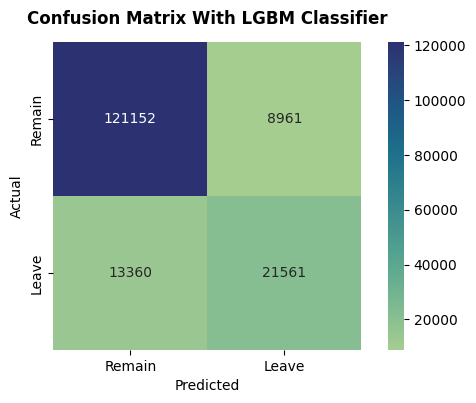

In [49]:
predicted_lgbm_classifier = cross_val_predict(LGBM, transformed_data, y, cv=skf)
conf_matrix_lgbm_classifier = confusion_matrix(y, predicted_lgbm_classifier)

class_names = ['Remain', 'Leave']

plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix_lgbm_classifier, annot=True, fmt='d', cmap='crest', square=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix With LGBM Classifier', fontsize=12, fontweight='bold', pad=13)

plt.show()

# XGB

In [50]:
%%time
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 7),
        'random_state': 42,
        'lambda': trial.suggest_float('reg_lambda', 0, 1),
        'alpha': trial.suggest_float('reg_alpha', 0, 1),
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'device': 'cuda',
        'verbosity': 1,
}
    
    stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    xgb_model = XGBClassifier(**param)
    xgb_pipeline = make_pipeline(full_pipeline, xgb_model)
    
    f1_scores = []
    
    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgb_pipeline.fit(X_train, y_train)
        y_prob = xgb_pipeline.predict(X_test)

        f1 = f1_score(y_test, y_prob, average='weighted')
        f1_scores.append(f1)

    mean_f1_score = np.mean(f1_scores)
    return mean_f1_score

pruner = optuna.pruners.MedianPruner(n_warmup_steps=3)

if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', pruner=pruner)
    study.optimize(objective, n_trials=200, n_jobs=-1, show_progress_bar=True)

    best_params = study.best_params
    XGB_best_mean_accuracy = study.best_value

    print(f"Best Parameters: {best_params}")
    print(f"Best Mean Accuracy: {XGB_best_mean_accuracy:.6f}")

[I 2024-02-13 00:58:10,623] A new study created in memory with name: no-name-b287a067-7027-41e3-844c-70507a028b90


  0%|          | 0/200 [00:00<?, ?it/s]

[00:58:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



[I 2024-02-13 00:58:35,211] Trial 0 finished with value: 0.7915122744241609 and parameters: {'n_estimators': 226, 'learning_rate': 0.0280834479623742, 'max_depth': 7, 'objective': 'binary:logistic', 'min_child_weight': 6, 'subsample': 0.45608407525210626, 'colsample_bytree': 0.14194010386344225, 'gamma': 0.7519098962179803, 'scale_pos_weight': 4.484160280476088, 'reg_lambda': 0.810545493225161, 'reg_alpha': 0.06778726272669144}. Best is trial 0 with value: 0.7915122744241609.
[I 2024-02-13 00:58:45,096] Trial 2 finished with value: 0.7788859037801432 and parameters: {'n_estimators': 634, 'learning_rate': 0.028442207046795107, 'max_depth': 4, 'objective': 'binary:logistic', 'min_child_weight': 5, 'subsample': 0.8405039995646914, 'colsample_bytree': 0.6249265161562533, 'gamma': 0.885892561684439, 'scale_pos_weight': 6.438228712332733, 'reg_lambda': 0.8485518687115351, 'reg_alpha': 0.06883309688776318}. Best is trial 0 with value: 0.7915122744241609.
[I 2024-02-13 00:58:53,775] Trial 3 fi

In [51]:
XGB = XGBClassifier(**best_params, random_state=42)
XGB

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7470845103702123, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5784831654820859,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08594409803934278,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

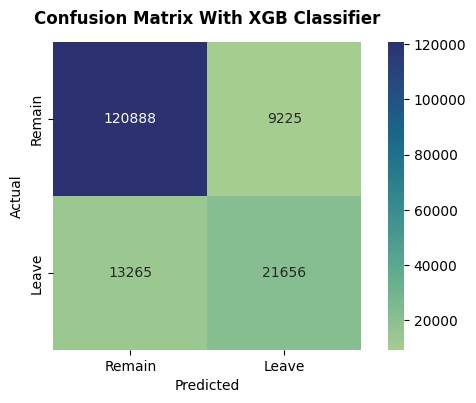

In [52]:
predicted_xgb_classifier = cross_val_predict(XGB, transformed_data, y, cv=skf)
conf_matrix_xgb_classifier = confusion_matrix(y, predicted_xgb_classifier)

class_names = ['Remain', 'Leave']

plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix_xgb_classifier, annot=True, fmt='d', cmap='crest', square=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix With XGB Classifier', fontsize=12, fontweight='bold', pad=13)

plt.show()

# Mutual Information

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff; font-size: 100%; text-align: left;">
    <b>📚 Mutual Information (MI):</b> Mutual Information (MI) is a measure of the dependence between two random variables. It quantifies how much knowing one variable can tell you about another variable. A higher MI score indicates a stronger relationship or dependency between the feature and the target variable.</div>


In [53]:
# Define a function to compute Mutual Information (MI) scores
def make_mi_score(X, y):
    
    # Compute MI scores for feature selection
    mi_score = mutual_info_classif(X, y, discrete_features='auto')
    
    # Create a Series to store MI scores with feature names
    mi_features = pd.Series(mi_score, name="MI Score", index=X.columns).sort_values(ascending=False)
    
    return mi_features

# Compute MI scores for the features in mi_df with respect to mi_y
mi_score = make_mi_score(transformed_df, y)
print(f"\033[34m{mi_score}")

cat__NumOfProducts_2             0.100593
num__Age                         0.082971
num__AgeBinning                  0.076225
cat__NumOfProducts_1             0.062645
num__TotalProductsUsed           0.046134
cat__IsActiveMember_1.0          0.044697
cat__IsActiveMember_0.0          0.037771
cat__CardActiveMember_0.0        0.037174
cat__Gender_Male                 0.031982
cat__CardActiveMember_1.0        0.029234
cat__Geography_France            0.028991
cat__HasCrCard_1.0               0.025400
cat__Gender_Female               0.023893
cat__Geography_Germany           0.023246
cat__CustomerStatus_Old          0.019945
cat__GeoGender_France_Male       0.019884
cat__GeoGender_Germany_Female    0.017728
cat__NumOfProducts_3             0.017663
num__Balance                     0.014627
num__BalanceSalaryRatio          0.012984
num__Surname_freq_encoded        0.011461
num__EstimatedSalary             0.008799
cat__GeoGender_Spain_Male        0.005532
cat__Geography_Spain             0

In [54]:
lgbm_pipeline = make_pipeline(full_pipeline, LGBM)
lgbm_pipeline.fit(X, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocessor',
                                  Pipeline(steps=[('age_binning',
                                                   AgeBinning(n_bins=5)),
                                                  ('creadit_binning',
                                                   CreaditBinning(n_bins=10)),
                                                  ('estimated_salary',
                                                   EstimatedSalary(n_bins=10)),
                                                  ('balance_salary_ratio',
                                                   BalanceSalaryRatio()),
                                                  ('geo_gender', GeoGender()),
                                                  ('card_active_member',
                                                   CardActiveMember()),
                                                  ('customer_status',
                                                   CustomerS...
                                                                    'IsActiveMember',
                                                                    'CardActiveMember'])]))])),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.6690374698262772,
                                learning_rate=0.050798711291155235, max_depth=6,
                                min_child_weight=5, n_estimators=270,
                                random_state=42, reg_alpha=0.8743998826982671,
                                reg_lambda=0.3165477256256351,
                                scale_pos_weight=1.342565241728834,
                                subsample=0.6741021126677645, verbosity=-1))])

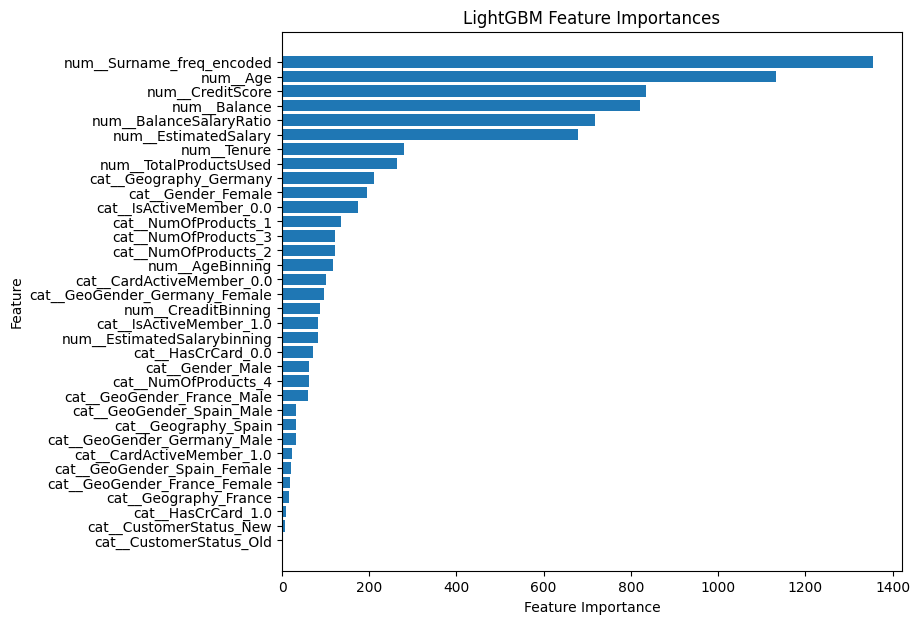

In [55]:
# Access the LightGBM model from the pipeline
lgbm_model = lgbm_pipeline.named_steps['lgbmclassifier']

# Get feature importances
feature_importances = lgbm_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

# Get feature names
column_names = full_pipeline.named_steps['column_transformer'].get_feature_names_out()

fig = plt.figure(figsize=(8, 7))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)),(column_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('LightGBM Feature Importances')
plt.show()

In [56]:
xgb_pipeline = make_pipeline(full_pipeline, XGB)
xgb_pipeline.fit(X, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocessor',
                                  Pipeline(steps=[('age_binning',
                                                   AgeBinning(n_bins=5)),
                                                  ('creadit_binning',
                                                   CreaditBinning(n_bins=10)),
                                                  ('estimated_salary',
                                                   EstimatedSalary(n_bins=10)),
                                                  ('balance_salary_ratio',
                                                   BalanceSalaryRatio()),
                                                  ('geo_gender', GeoGender()),
                                                  ('card_active_member',
                                                   CardActiveMember()),
                                                  ('customer_status',
                                                   CustomerS...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.08594409803934278, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=180, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

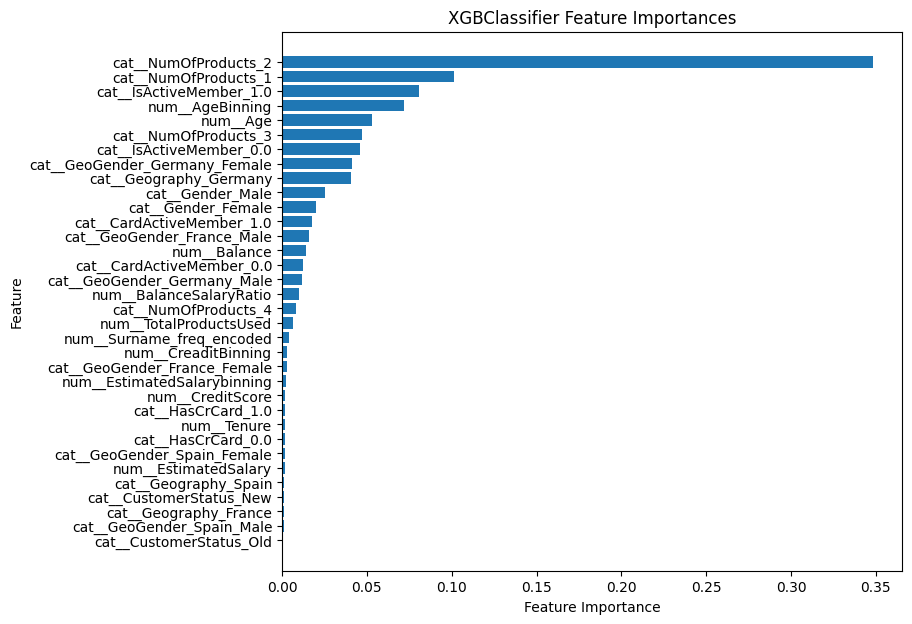

In [57]:
# Access the XGBClassifier model from the pipeline
xgb_model = xgb_pipeline.named_steps['xgbclassifier']

# Get feature importances
feature_importances = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

# Get feature names
column_names = full_pipeline.named_steps['column_transformer'].get_feature_names_out()

fig = plt.figure(figsize=(8, 7))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)),(column_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBClassifier Feature Importances')
plt.show()

# Evaluation Metrics

In [58]:
def accuracy(model, name):
    stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f'-----{name}-----', end="\n\n")

    accuracies = []

    for fold, (train_index, test_index) in enumerate (stratified_kf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_prob)
        print(f'Fold {fold + 1}, AUC Score - {auc}')
        accuracies.append(auc)

    mean_accuracy = np.mean(accuracies)
    std_cv_accuracy = np.std(accuracies)

    print(f'\n{name} With Stratified Cross-Validation Accuracy (Mean): {mean_accuracy:.6f}')
    print(f'{name} With Stratified Cross-Validation Accuracy (Standard deviation): {std_cv_accuracy:.6f}', end="\n\n\n\n")

In [59]:
best_hyperparmeters_lgbm = {'n_estimators': 242, 'learning_rate': 0.05913248747129516, 'max_depth': 7, 
                            'min_child_weight': 1, 'scale_pos_weight': 1.4789869477449946, 'reg_lambda': 0.12150427368456805, 
                            'reg_alpha': 0.5002769410944929, 'subsample': 0.8197549303426241, 'colsample_bytree': 0.34511631173834795}

In [60]:
lgbm_best = LGBMClassifier(**best_hyperparmeters_lgbm, verbosity=-1, random_state=42)

In [61]:
lgbm_best_pipeline = make_pipeline(full_pipeline, lgbm_best)

In [62]:
accuracy(lgbm_best_pipeline, 'lgbm_best_pipeline')
accuracy(lgbm_pipeline, 'lgbm_pipeline')
accuracy(xgb_pipeline, 'xgb_pipeline')

-----lgbm_best_pipeline-----

Fold 1, AUC Score - 0.892405680515505
Fold 2, AUC Score - 0.8928705800785357
Fold 3, AUC Score - 0.8938189409632742
Fold 4, AUC Score - 0.894027194763398
Fold 5, AUC Score - 0.8910720661466907

lgbm_best_pipeline With Stratified Cross-Validation Accuracy (Mean): 0.892839
lgbm_best_pipeline With Stratified Cross-Validation Accuracy (Standard deviation): 0.001066



-----lgbm_pipeline-----

Fold 1, AUC Score - 0.8926497234867437
Fold 2, AUC Score - 0.8925967783191527
Fold 3, AUC Score - 0.8935710436828747
Fold 4, AUC Score - 0.893550526351058
Fold 5, AUC Score - 0.8907687497969601

lgbm_pipeline With Stratified Cross-Validation Accuracy (Mean): 0.892627
lgbm_pipeline With Stratified Cross-Validation Accuracy (Standard deviation): 0.001020



-----xgb_pipeline-----

Fold 1, AUC Score - 0.8917466981913392
Fold 2, AUC Score - 0.8920263570700673
Fold 3, AUC Score - 0.8927175714328663
Fold 4, AUC Score - 0.8933050234956192
Fold 5, AUC Score - 0.8899722444960881



# VotingClassifier

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 VotingClassifier :</b> It is a technique that combines the predictions from multiple base classifiers to make a final prediction. The idea behind a voting classifier is to leverage the diversity of multiple models to improve the overall predictive accuracy. This is particularly useful when the base classifiers have different strengths and weaknesses. By combining them, the ensemble can mitigate the weaknesses of individual models and yield better overall performance.
<br><br>
There are two main types of voting classifiers:
<br><br>
<ul>
    <li><b>Hard Voting Classifier :</b> In a hard voting classifier, each base classifier predicts a class label, and the class that receives the majority of the votes is selected as the final prediction.</li>
    <br>
    <li><b>Soft Voting Classifier :</b> In a soft voting classifier, each base classifier calculates the probability or confidence score associated with its prediction for a given class label. These probabilities are then averaged for each class label, and the class with the highest average probability is selected as the final prediction.</li>
</ul>
</div>

In [63]:
voting_classifier = VotingClassifier(estimators=[
    ('lgbm', lgbm_pipeline),
    ('xgb', xgb_pipeline),
    ('lgbm_best_model', lgbm_best_pipeline),
        
], n_jobs=-1, voting='soft', weights=[0.5,0.3,0.4])

In [64]:
voting_classifier

VotingClassifier(estimators=[('lgbm',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('preprocessor',
                                                                Pipeline(steps=[('age_binning',
                                                                                 AgeBinning(n_bins=5)),
                                                                                ('creadit_binning',
                                                                                 CreaditBinning(n_bins=10)),
                                                                                ('estimated_salary',
                                                                                 EstimatedSalary(n_bins=10)),
                                                                                ('balance_salary_ratio',
                                                                                 BalanceSalaryRatio()),
                                                                                ('geo_gender',
                                                                                 GeoGender()),
                                                                                ('card_active_member',
                                                                                 CardActiveM...
                                              ('lgbmclassifier',
                                               LGBMClassifier(colsample_bytree=0.34511631173834795,
                                                              learning_rate=0.05913248747129516,
                                                              max_depth=7,
                                                              min_child_weight=1,
                                                              n_estimators=242,
                                                              random_state=42,
                                                              reg_alpha=0.5002769410944929,
                                                              reg_lambda=0.12150427368456805,
                                                              scale_pos_weight=1.4789869477449946,
                                                              subsample=0.8197549303426241,
                                                              verbosity=-1))]))],
                 n_jobs=-1, voting='soft', weights=[0.5, 0.3, 0.4])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to 

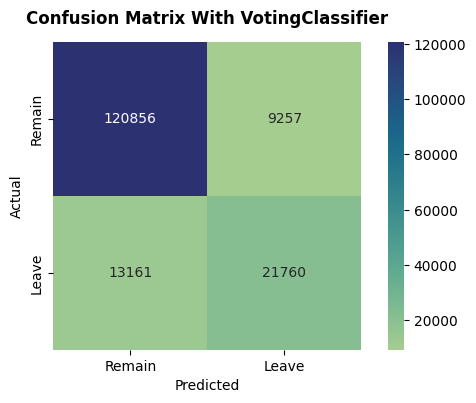

In [65]:
predicted_voting_classifier = cross_val_predict(voting_classifier, X, y, cv=skf)
conf_matrix_voting_classifier_classifier = confusion_matrix(y, predicted_voting_classifier)

class_names = ['Remain', 'Leave']

plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix_voting_classifier_classifier, annot=True, fmt='d', cmap='crest', square=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix With VotingClassifier', fontsize=12, fontweight='bold', pad=13)

plt.show()

In [66]:
accuracy(voting_classifier, 'voting_classifier')

-----voting_classifier-----

Fold 1, AUC Score - 0.8926277751080979
Fold 2, AUC Score - 0.8928431514830105
Fold 3, AUC Score - 0.8938190620122415
Fold 4, AUC Score - 0.8939406620695983
Fold 5, AUC Score - 0.8910258786886028

voting_classifier With Stratified Cross-Validation Accuracy (Mean): 0.892851
voting_classifier With Stratified Cross-Validation Accuracy (Standard deviation): 0.001049





# Results

In [67]:
def submission(model, name, filename):
    if (name != 'voting_classifier'):
        model_pipeline = make_pipeline(full_pipeline, model)
    else:
        model_pipeline = model
    
    model_pipeline.fit(X, y)
    
    y_pred_best = model_pipeline.predict_proba(df_bankChunk_test)[:, 1]
    bankChunk_submission = bankChunk_test[['id']].copy()
    bankChunk_submission['Exited'] = y_pred_best.flatten()
    
    bankChunk_submission.to_csv(f"{filename}_submit.csv", index=False)

In [68]:
submission(LGBM, 'LGBM', 'lgbm')

In [69]:
submission(XGB, 'XGB', 'xgb')

In [70]:
submission(voting_classifier, 'voting_classifier', 'voting_lgbm_xgb')